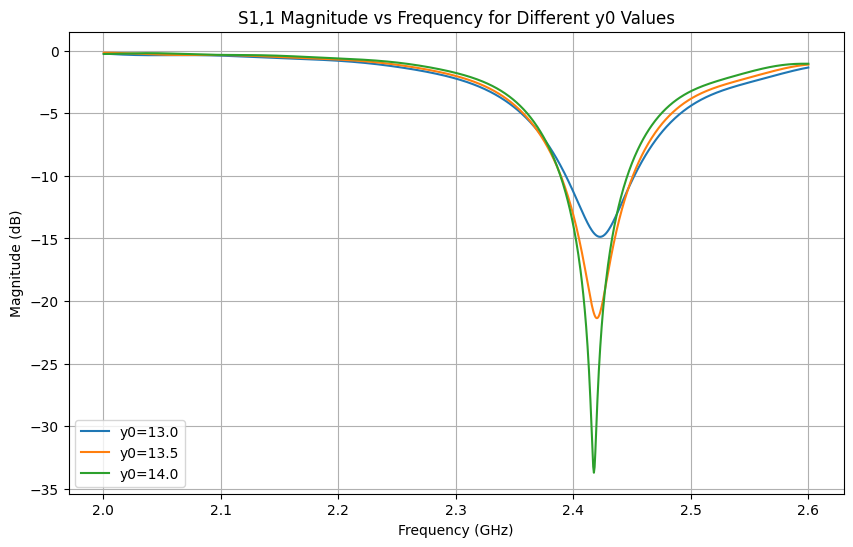

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the file paths
file_path = 'CST_Data/S11_Sweep.txt'

# Define the line ranges for each y0 value
ranges = {
    'y0=13.0': (4, 1004),
    'y0=13.5': (1008, 2008),
    'y0=14.0': (2012, 3012)
}

# Initialize empty DataFrames to store all data
df = pd.DataFrame()

# Read the first file and extract data for each y0 value
for y0, (start, end) in ranges.items():
    data = pd.read_csv(file_path, skiprows=start, nrows=end-start, delimiter='\t', names=["Frequency / GHz", f"{y0}"])
    if df.empty:
        df = data
    else:
        df = pd.merge(df, data, on="Frequency / GHz")

# Plot the data from the first file
plt.figure(figsize=(10, 6))
for column in df.columns[1:]:
    plt.plot(df["Frequency / GHz"], df[column], label=column)

plt.title('S1,1 Magnitude vs Frequency for Different y0 Values')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.grid(True)
plt.show()

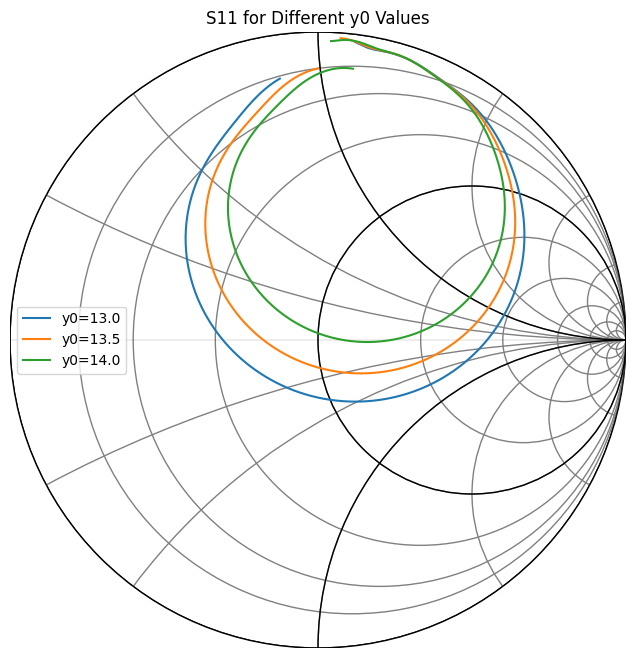

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import skrf as rf
import numpy as np

file_path = 'CST_Data/S11_Sweep_Smith.txt'

ranges = {
    'y0=13.0': (4, 1004),
    'y0=13.5': (1008, 2008),
    'y0=14.0': (2012, 3012)
}

# Dictionary to store Network objects
networks = {}

# Read the file and extract data for each y0 value
for y0, (start, end) in ranges.items():
    data = pd.read_csv(file_path, skiprows=start, nrows=end-start, delimiter='\t', names=["Frequency", "Mag", "Phase", "Ref Mag", "Ref Phase"])
    frequency = data["Frequency"].values * 1e9  # Convert GHz to Hz
    s11_mag = data["Mag"].values
    s11_phase = data["Phase"].values
    s11_complex = s11_mag * np.exp(1j * np.deg2rad(s11_phase))
    networks[y0] = rf.Network(frequency=frequency, s=s11_complex)

# Plot S11 on Smith Chart
fig, ax = plt.subplots(figsize=(8, 8))
for y0, network in networks.items():
    network.plot_s_smith(ax=ax, label=y0)

# Add title and legend
ax.set_title('S11 for Different y0 Values')
ax.legend()

# Set axis limits and labels
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

# Add grid and ticks
ax.grid(True, which='both')
ax.tick_params(axis='both', which='both', direction='in', length=6, width=2, colors='black', grid_color='gray', grid_alpha=0.5)

# Show the plot
plt.show()